The [SoundingsSupport](https://python-awips.readthedocs.io/en/latest/api/SoundingsSupport.html) class allows us to create a vertical sounding from any available AWIPS model.

In [13]:
from awips.dataaccess import SoundingsSupport
from awips.dataaccess import DataAccessLayer
from shapely.geometry import Point
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from metpy.units import units

model  = 'NAM40'
parms  = ['T','DpT','wSp','uW','vW']
all_pres_levels = ['50.0MB','75.0MB','100.0MB','125.0MB','150.0MB','175.0MB',
               '200.0MB','225.0MB','250.0MB','275.0MB','300.0MB','325.0MB',
               '350.0MB','375.0MB','400.0MB','425.0MB','450.0MB','475.0MB',
               '500.0MB','525.0MB','550.0MB','575.0MB','600.0MB','625.0MB',
               '650.0MB','675.0MB','700.0MB','725.0MB','750.0MB','775.0MB',
               '800.0MB','825.0MB','850.0MB','875.0MB','900.0MB','925.0MB',
               '950.0MB','975.0MB','1000.0MB']
pres_levels = ['100.0MB','200.0MB','300.0MB','400.0MB','500.0MB','600.0MB',
               '700.0MB','800.0MB','900.0MB','1000.0MB']
height_levels = ['0.0FHAG', '100.0FHAG', '500.0FHAG', 
                '750.0FHAG', '1000.0FHAG', '1250.0FHAG', '1500.0FHAG', 
                '2000.0FHAG', '2500.0FHAG', '3000.0FHAG', '3500.0FHAG', 
                '4000.0FHAG', '4500.0FHAG', '5000.0FHAG', '5500.0FHAG', 
                '6000.0FHAG', '7000.0FHAG', '7620.0FHAG', '8000.0FHAG', 
                '9000.0FHAG', '10000.0FHAG']
# use KDEN lat/lon
envelope = Point(39.87, -104.67)

server = 'edex-cloud.unidata.ucar.edu'
DataAccessLayer.changeEDEXHost(server)
request = DataAccessLayer.newDataRequest("grid", envelope=envelope)
request.setLocationNames(model)
request.setParameters('T')
response = DataAccessLayer.getAvailableTimes(request, True)
cycle = response[1]
refTime = cycle.getValidPeriod().getStart()
print(cycle.getValidPeriod())

SoundingsSupport.changeEDEXHost(server)
sndObject = SoundingsSupport.getSounding(
    model, parms, all_pres_levels, envelope, refTime=refTime)
print("Found " + str(len(sndObject)) + " records")

(Oct 12 18 00:00:00 , Oct 12 18 00:00:00 )


In [15]:
pres, tmpc, dwpt, wsp, u, v = [], [], [], [], [], []

for t in sndObject._dataDict: # times
    if t.getFcstTime() == 0: # analysis time only
        for lvl in sndObject._dataDict[t].levels(): # levels 
            for parm in sndObject._dataDict[t][lvl].parameters(): # parms
                if parm == "T":
                    tmpc.append(float(sndObject._dataDict[t][lvl][parm]))
                elif parm == "DpT":
                    dwpt.append(float(sndObject._dataDict[t][lvl][parm]))                
                elif parm == 'wSp':
                    wsp.append(float(sndObject._dataDict[t][lvl][parm])) 
                elif parm == 'uW':
                    u.append(float(sndObject._dataDict[t][lvl][parm])) 
                elif parm == 'vW':
                    v.append(float(sndObject._dataDict[t][lvl][parm])) 
                elif parm == 'P':
                    pres.append(float(sndObject._dataDict[t][lvl][parm]))

pres = np.flip(np.array([l.replace('MB','') for l in all_pres_levels], dtype=float))
tmpc = (np.array(tmpc)-273.15) * units.degC
dwpt = (np.array(dwpt)-273.15) * units.degC
wsp = np.array(wsp, dtype=float)
u = np.array(u, dtype=float)
v = np.array(v, dtype=float)

50.0 1000.0


---

## MetPy SkewT and Hodograph

39 39 39 39


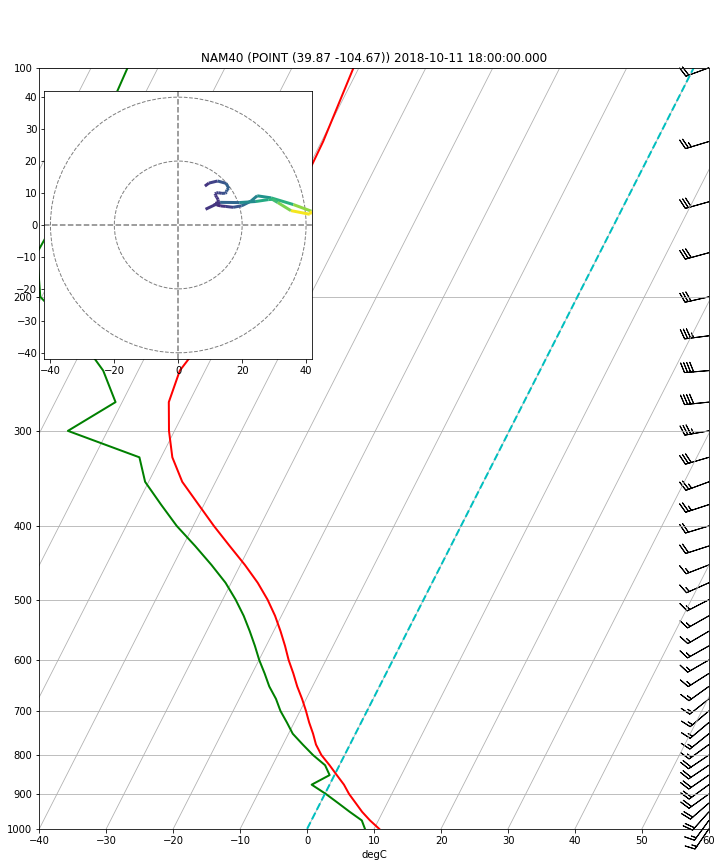

In [16]:
%matplotlib inline
from metpy.plots import SkewT, Hodograph
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rcParams['figure.figsize'] = (12, 14)
# Create a skewT plot
skew = SkewT()
# Plot the data
skew.plot(pres, tmpc, 'r', linewidth=2)
skew.plot(pres, dwpt, 'g', linewidth=2)
skew.plot_barbs(pres, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)
plt.title( model + " (" + str(envelope) + ") " + str(response[0].getRefTime()))
# An example of a slanted line at constant T -- in this case the 0 isotherm
l = skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)
# Draw hodograph
ax_hod = inset_axes(skew.ax, '40%', '40%', loc=2)
h = Hodograph(ax_hod, component_range=wsp.max())
h.add_grid(increment=20)
h.plot_colormapped(u, v, wsp)
# Show the plot
plt.show()

In [ ]:
# TODO: use FHAG as levels and retrieve pres as a parameter